In [1]:
# This analysis is very similar to Vix and S&P 500 analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# We do our initial tests with Bitcoin. We can expand this analysis later
coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)

coin_df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2013-04-29,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Next we read in DJIA Dataset
djia_df = pd.read_csv('index_data/djia_HistoricalPrices.csv')

new_column_names = {}
for col in djia_df.columns:
    new_column_names[col] = col.strip()
djia_df.rename(columns=new_column_names, inplace=True)

djia_df.index = pd.to_datetime(djia_df['Date']).dt.date
djia_df.index = pd.DatetimeIndex(djia_df.index)

djia_df.drop('Date', axis=1, inplace=True)

# for col in djia_df.columns:
#     print(col, len(col.strip()))
# djia_df['Close']
djia_df.head()
# print(djia_df.index[0])
# djia_df.loc['2021-03-26']

,Open,High,Low,Close
Date,,,,
2021-03-26,32681.07,33098.83,32681.07,33072.88
2021-03-25,32346.81,32672.69,32071.41,32619.48
2021-03-24,32470.88,32787.99,32418.15,32420.06
2021-03-23,32691.50,32753.77,32356.28,32423.15
2021-03-22,32601.82,32810.35,32512.53,32731.20


In [4]:
# We now need to preprocess our data some more. We need to make sure that the dates in our dataframes appear in both
coin_dates = set(coin_df.index)
djia_dates = set(djia_df.index)
shared_dates = djia_dates.intersection(coin_dates)

for date in djia_dates.difference(shared_dates):
    djia_df.drop(date, inplace=True)
for date in coin_dates.difference(shared_dates):
    coin_df.drop(date, inplace=True)

print(len(coin_df))
print(len(djia_df))

1975
1975


In [5]:
# Now let's make a new dataframe for coin return:
coin_return = pd.DataFrame(index=coin_df.index)
coin_return['coin_return'] = coin_df['Close'].pct_change()
djia_df['return'] = djia_df['Close'].pct_change()

# Now the first row will have a NaN value. So we drop it in both sp_df and coin_return
coin_return.drop(coin_return.index[0], inplace=True)
djia_df_copy = djia_df.drop(coin_return.index[0])

# Furthermore, the highs in the S&P 500 dataset are sometimes 0. We should get rid of those dates in both sets of data
zero_indeces = []
for index in djia_df_copy.index:
    if djia_df_copy.loc[index]['High'] == 0:
        zero_indeces += [index]

djia_df_copy.drop(zero_indeces, inplace=True)
coin_return.drop(zero_indeces, inplace=True)


Text(0, 0.5, 'Coin Return Percentage')

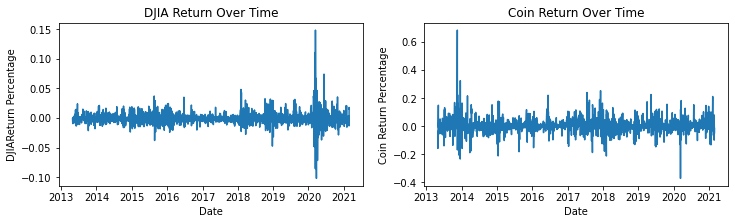

In [6]:
# Now let's do some basic data visualizations
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(djia_df_copy.index, djia_df_copy['return'])
ax1.set_title('DJIA Return Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('DJIAReturn Percentage')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(coin_return.index, coin_return['coin_return'])
ax2.set_title('Coin Return Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Coin Return Percentage')

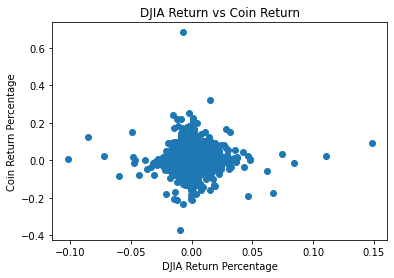

In [7]:
# Now let's try DJIA High vs Coin Return
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(djia_df_copy['return'], coin_return['coin_return'])
ax1.set_title("DJIA Return vs Coin Return")
ax1.set_xlabel("DJIA Return Percentage")
ax1.set_ylabel("Coin Return Percentage")
plt.show()

In [8]:
# We want to do a similar analysis as Vix-analysis and S&P 500 analysis. Our output is again sentiment
# > .2 then very good 0 < < 0.2 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.2:
        return 'very good'
    elif return_val > 0 and return_val < 0.2:
        return 'good'
    elif return_val < 0 and return_val > -0.2:
        return 'bad'
    elif return_val <= 0.2:
        return 'very bad'
    else:
        return None
    
coin_sentiment = pd.DataFrame(index=coin_return.index)
coin_sentiment['sentiment'] = [get_sentiment(return_val) for return_val in coin_return['coin_return']]

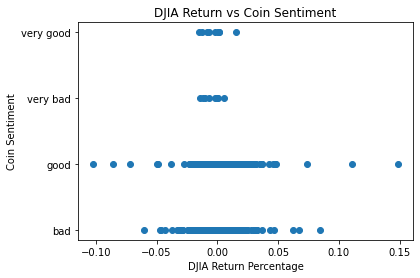

In [9]:
# Visualize this new data again
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(djia_df_copy['return'], coin_sentiment['sentiment'])
ax1.set_title("DJIA Return vs Coin Sentiment")
ax1.set_xlabel("DJIA Return Percentage")
ax1.set_ylabel("Coin Sentiment")
plt.show()

In [10]:
# Let's do our data split
X_train, X_test, Y_train, Y_test = train_test_split(djia_df_copy['High'], coin_sentiment['sentiment'], test_size=0.2, random_state=0)
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)


In [11]:
# An SVM looks to be useful here with the clustered data
model = SVC()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

In [12]:
accuracy_score(y_pred, Y_test)

0.5265822784810127

In [13]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

In [14]:
accuracy = accuracy_score(y_pred, Y_test)

In [15]:
from math import sqrt
# Calculate Confidence intervals
z = 1.96 # 95% confidence interval
n = len(y_pred)
interval = z * sqrt( (accuracy * (1 - accuracy)) / n)
print(f'Model accuracy: {accuracy} +/- {interval}')

Model accuracy: 0.5265822784810127 +/- 0.049239416599790815
